# Anomaly Detection

In this notebook, we will explore Variational Auto Encoders as a way to detect anomalies on streamed data.

1. Train model using Keras
2. Convert to compressed floating point version using Tensorflow Lite
3. Optimise for more efficient integers
4. Deploy on Raspberry Pi

We will use this dataset, which is gathered from a smart factory in Germany: https://www.kaggle.com/inIT-OWL/versatileproductionsystem

Other Similar Datasets:
- https://www.kaggle.com/inIT-OWL/high-storage-system-data-for-energy-optimization,
- https://www.kaggle.com/tocha4/predictive-maintenance-basics-about-dataset
- https://www.kaggle.com/inIT-OWL/one-year-industrial-component-degradation
- http://odds.cs.stonybrook.edu/

References:
- https://thingsolver.com/time-series-anomaly-detection-using-a-variational-autoencoder-vae/
- https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/convert/python_api.md
- https://www.tensorflow.org/lite/microcontrollers/build_convert

## Setup

### Install Keras (which includes Tensorflow).

```
conda install keras-cpu
```

#### GPU (Optional)
If you have a GPU on your computer, TF 1.13 and above requires CUDA 10. If no NVidia GPU is available on your computer, install keras-cpu instead
- https://www.tensorflow.org/install/gpu
- https://developer.nvidia.com/cuda-10.1-download-archive

```
# Don't run this unless you have a GPU setup with CUDA 10
conda install keras-gpu
```

### Install other libraries (plotting, pre-processing):
```
conda install pandas matplotlib scikit-learn pydot
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Data Exploration

The dataset is provided in the github repository, under the `data` folder. You can read about the dataset on Kaggle: https://www.kaggle.com/inIT-OWL/versatileproductionsystem

In [2]:
df = pd.read_csv('./../data/versatileproductionsystem/Filling_ALL.module.csv', index_col=0)
df.head()

,I_BottleAtAirpipe,I_BottleClampClose,I_BottleClampOpen,I_BottleGateClosed,I_BottleReserveGateClosed,I_BottlesAvailable,I_BottleSlot1,I_BottleSlot2_H2O,I_BottleSlot3_Corn,I_BottleSlot5_CapOn,...,BottlesAvailable.AnalogValue.EURangeViolation,BottleSlot1.AnalogValue.EURangeViolation,BottleSlot2_H2O.AnalogValue.EURangeViolation,BottleSlot3_Corn.AnalogValue.EURangeViolation,BottleSlot5_CapOn.AnalogValue.EURangeViolation,BottleSlot6_CapCloser.AnalogValue.EURangeViolation,BottleSlot8_ModuleOut.AnalogValue.EURangeViolation,BottlesNotUsed.AnalogValue.EURangeViolation,UltraSonic_Corn.DistanceM.EURangeViolation,UltraSonic_H2O.DistanceM.EURangeViolation
Timestamp,,,,,,,,,,,,,,,,,,,,,
1529500027127,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1529500027227,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1529500027327,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1529500027428,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1529500027528,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.describe()

,I_BottleAtAirpipe,I_BottleClampClose,I_BottleClampOpen,I_BottleGateClosed,I_BottleReserveGateClosed,I_BottlesAvailable,I_BottleSlot1,I_BottleSlot2_H2O,I_BottleSlot3_Corn,I_BottleSlot5_CapOn,...,BottlesAvailable.AnalogValue.EURangeViolation,BottleSlot1.AnalogValue.EURangeViolation,BottleSlot2_H2O.AnalogValue.EURangeViolation,BottleSlot3_Corn.AnalogValue.EURangeViolation,BottleSlot5_CapOn.AnalogValue.EURangeViolation,BottleSlot6_CapCloser.AnalogValue.EURangeViolation,BottleSlot8_ModuleOut.AnalogValue.EURangeViolation,BottlesNotUsed.AnalogValue.EURangeViolation,UltraSonic_Corn.DistanceM.EURangeViolation,UltraSonic_H2O.DistanceM.EURangeViolation
count,10529.000000,10529.000000,10529.000000,10529.000000,10529.000000,10529.000000,10529.000000,10529.000000,10529.000000,10529.000000,...,10529.0,10529.0,10529.0,10529.0,10529.0,10529.0,10529.0,10529.0,10529.0,10529.0
mean,0.011207,0.254155,0.716497,0.973597,0.994871,0.973977,0.004274,0.688100,0.692089,0.712603,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.105274,0.435406,0.450720,0.160339,0.071434,0.159212,0.065238,0.463291,0.461652,0.452570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# filter out low variance columns and plot them
high_variance_cols = df.columns[df.std() > 0.25]

high_variance_cols

Index(['I_BottleClampClose', 'I_BottleClampOpen', 'I_BottleSlot2_H2O',
       'I_BottleSlot3_Corn', 'I_BottleSlot5_CapOn', 'I_BottleSlot6_CapScrewer',
       'I_BottlesReserveAvailable', 'I_CapGrabberUp', 'I_CapScrewer_Up',
       'I_CapScrewerClosePos', 'I_CapScrewerGrabClosed', 'I_CapScrewerOpenPos',
       'I_LinAxisCapInGrabber', 'I_LinAxisDown', 'I_LinAxisEmptyGrabber',
       'I_LinAxisUp', 'I_Pump_Down', 'I_RotaryTablePosReached',
       'I_UltrasonicCorn', 'I_UltrasonicCorn_Distance',
       'I_UltrasonicH2O_Distance', 'O_BottleClampClose',
       'O_CapGrabberOpenClose', 'O_CapGrabberUpDown', 'O_CapScrewDown',
       'O_CapScrewerGrabberOpenClose', 'O_CloseCap', 'O_ConveyorCapsForward',
       'O_LinAxisUpDown', 'O_PumpUpDown', 'O_RotaryTable',
       'O_ValvePumpCloseOpen', 'PendingOrder', 'Rotating', 'State',
       'BottlesAvailable', 'BottleSlot1', 'BottleSlot2_H2O',
       'BottleSlot3_Corn', 'BottleSlot5_CapOn', 'BottleSlot6_CapCloser',
       'BottleSlot8_ModuleOut', 'B

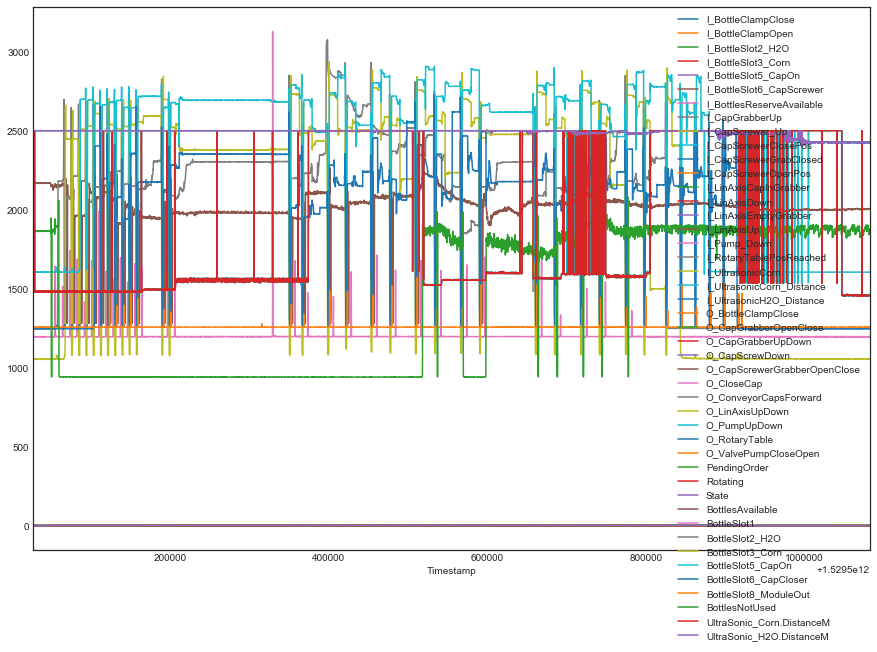

In [5]:
fig, ax = plt.subplots(figsize=(15, 10))
df[high_variance_cols].plot(ax=ax)
plt.show()

In [6]:
# There are still columns with low mean, let's plot them

df1 = df[high_variance_cols]
low_mean_cols = df1.columns[df1.mean() < 5]
low_mean_cols

Index(['I_BottleClampClose', 'I_BottleClampOpen', 'I_BottleSlot2_H2O',
       'I_BottleSlot3_Corn', 'I_BottleSlot5_CapOn', 'I_BottleSlot6_CapScrewer',
       'I_BottlesReserveAvailable', 'I_CapGrabberUp', 'I_CapScrewer_Up',
       'I_CapScrewerClosePos', 'I_CapScrewerGrabClosed', 'I_CapScrewerOpenPos',
       'I_LinAxisCapInGrabber', 'I_LinAxisDown', 'I_LinAxisEmptyGrabber',
       'I_LinAxisUp', 'I_Pump_Down', 'I_RotaryTablePosReached',
       'I_UltrasonicCorn', 'O_BottleClampClose', 'O_CapGrabberOpenClose',
       'O_CapGrabberUpDown', 'O_CapScrewDown', 'O_CapScrewerGrabberOpenClose',
       'O_CloseCap', 'O_ConveyorCapsForward', 'O_LinAxisUpDown',
       'O_PumpUpDown', 'O_RotaryTable', 'O_ValvePumpCloseOpen', 'PendingOrder',
       'Rotating', 'State'],
      dtype='object')

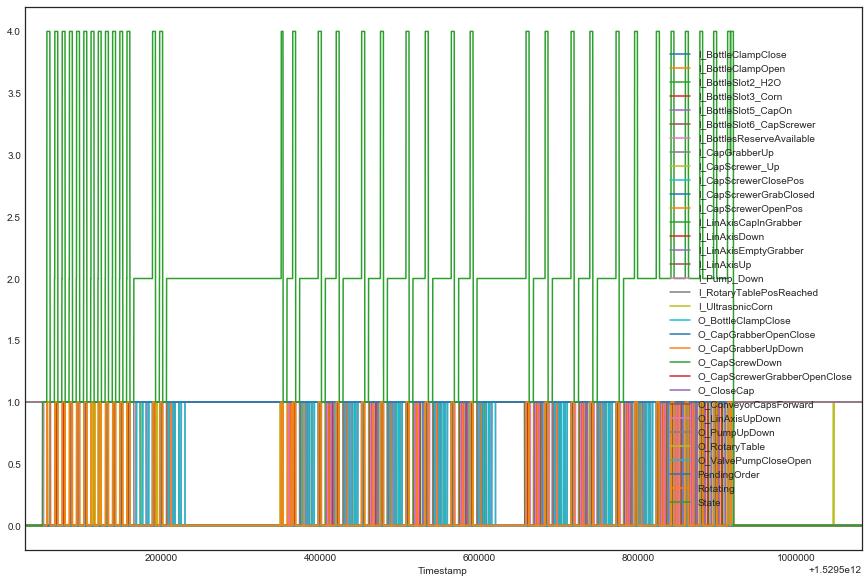

In [7]:
fig, ax = plt.subplots(figsize=(15, 10))
df1[low_mean_cols].plot(ax=ax)
plt.show()

In [8]:
# these are the high mean columns
high_mean_cols = set(df1.columns).difference(low_mean_cols)
high_mean_cols

{'BottleSlot1',
 'BottleSlot2_H2O',
 'BottleSlot3_Corn',
 'BottleSlot5_CapOn',
 'BottleSlot6_CapCloser',
 'BottleSlot8_ModuleOut',
 'BottlesAvailable',
 'BottlesNotUsed',
 'I_UltrasonicCorn_Distance',
 'I_UltrasonicH2O_Distance',
 'UltraSonic_Corn.DistanceM',
 'UltraSonic_H2O.DistanceM'}

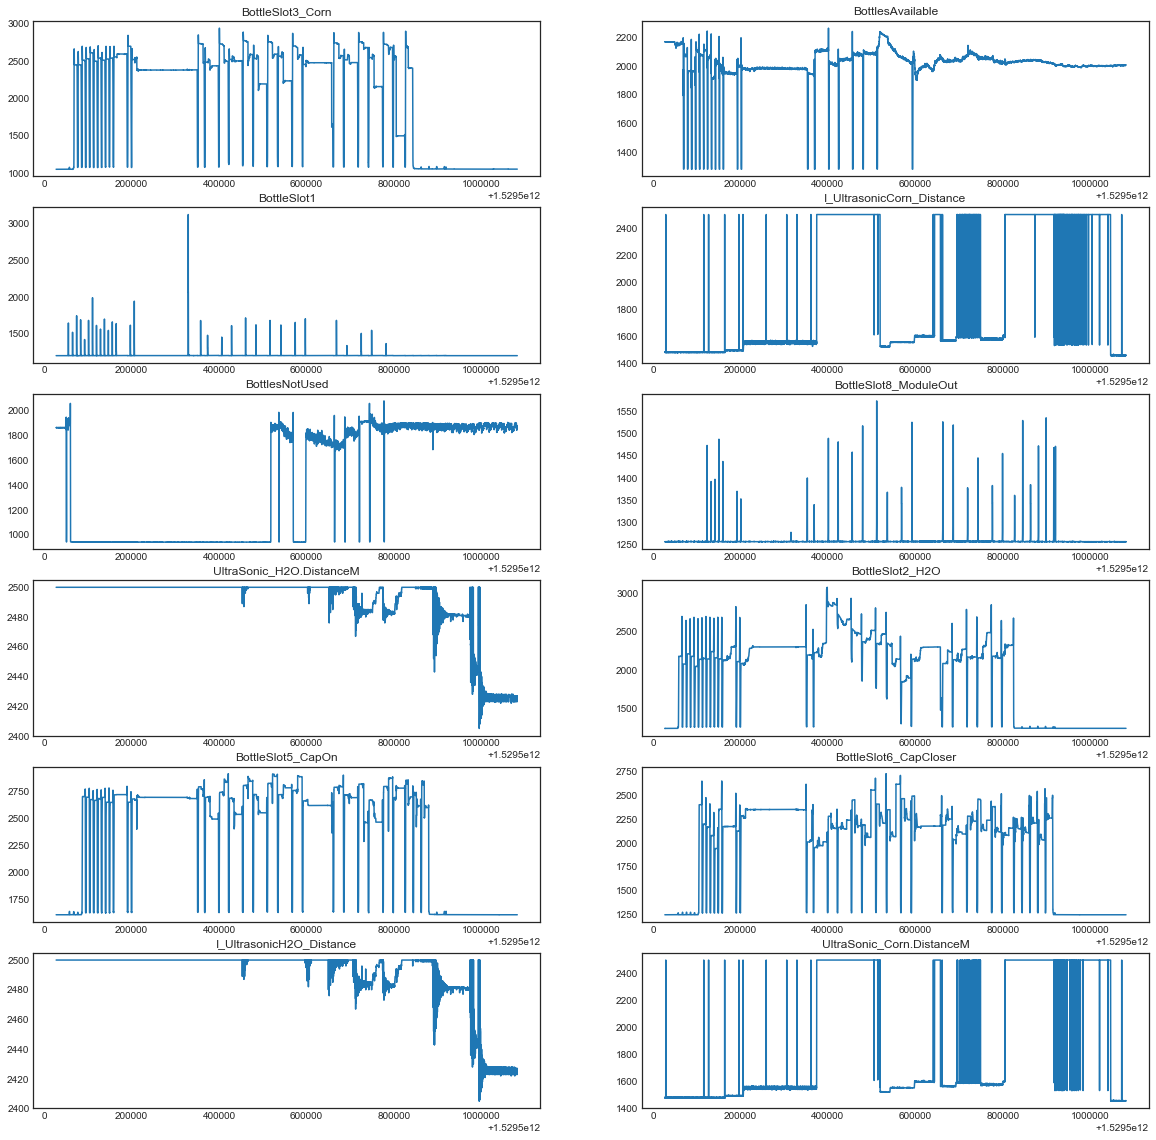

In [9]:
fig, axes = plt.subplots(nrows=len(high_mean_cols)//2, ncols=2, figsize=(20, 20))
axes = axes.flatten()
for ax, column in zip(axes, high_mean_cols):
    ax.plot(df1[column])
    ax.set(title=column)
plt.show()

In [10]:
# pick one of the variables to do anomaly detection
series = 'BottlesNotUsed'

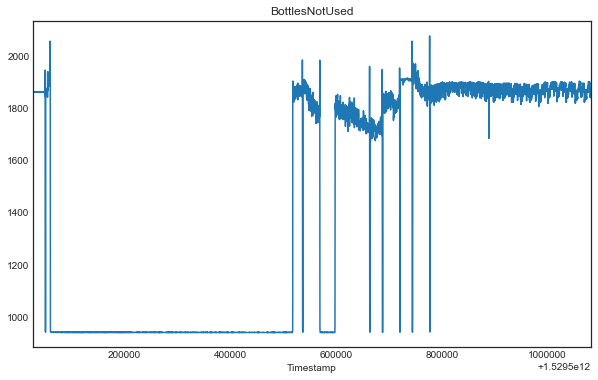

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
df1[series].plot(ax=ax)
ax.set(title=series)
plt.show()

C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\diec\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\diec\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


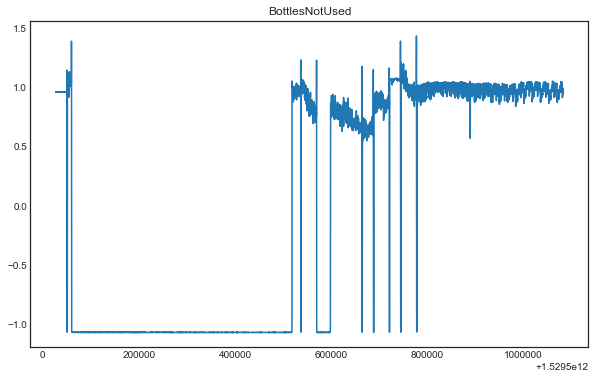

In [12]:
# scale and plot again
scaler = StandardScaler()
scaled_df1 = scaler.fit_transform(df1)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df1.index, scaled_df1[:, df1.columns == series])
ax.set(title=series)
plt.show()

## Featurizing

To create features from a time series, we typically create windowed versions of each series.

For example:
x[t] becomes x[t-2], x[t-1], x[t], if the window is 3. This will create 3 columns instead of 1 column, and capture the history of the time series.

If there are multiple series, windowed versions of each series can be appended as new columns.

One way to think about this is that time adds another dimension, and that dimension is represented as new columns for the same feature.

In [13]:
df_series = pd.DataFrame(scaled_df1[:, df1.columns == series])
df_series.head()

,0
0,0.962853
1,0.962853
2,0.962853
3,0.962853
4,0.960656


In [14]:
df_series.shift(-1).head() # shift up by 1

,0
0,0.962853
1,0.962853
2,0.962853
3,0.960656
4,0.962853


In [15]:
def make_windowed_dataframe(array, window_size):
    """Returns a dataframe containing windowed versions of a series"""
    result = pd.concat([pd.DataFrame(array).shift(-i) for i in range(window_size)], axis=1)
    result.columns = [f't+{i}' for i in range(window_size)]
    result.dropna(inplace=True)
    return result

make_windowed_dataframe(scaled_df1[:, df1.columns == series], 5).head()

,t+0,t+1,t+2,t+3,t+4
0,0.962853,0.962853,0.962853,0.962853,0.960656
1,0.962853,0.962853,0.962853,0.960656,0.962853
2,0.962853,0.962853,0.960656,0.962853,0.962853
3,0.962853,0.960656,0.962853,0.962853,0.960656
4,0.960656,0.962853,0.962853,0.960656,0.962853


## Model

This model is based heavily on VAE example from Keras, with some extra Dense layers to improve modeling power:
https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py

The reconstruction loss can be used to detect anomalies.

Other VAE examples:
- https://www.kaggle.com/hone5com/fraud-detection-with-variational-autoencoder

In [16]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.utils import plot_model
from keras import backend as K
from keras.losses import mse

class VAE:
    def __init__(self, original_dim, intermediate_dim, latent_dim):
        """Creates a variational autoencoder for continuous values
        """
        self.original_dim = original_dim
        input_shape = (original_dim,)
        
        # VAE model = encoder + decoder
        # build encoder model
        inputs = Input(shape=input_shape, name='encoder_input')
        x = Dense(intermediate_dim, activation='relu')(inputs)
        x = Dense(intermediate_dim, activation='relu')(x)
        self.z_mean = Dense(latent_dim, name='z_mean')(x)
        self.z_log_var = Dense(latent_dim, name='z_log_var')(x)
        
        # use reparameterization trick to push the sampling out as input
        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(VAE.sampling, output_shape=(latent_dim,), name='z')([self.z_mean, self.z_log_var])
        
        # instantiate encoder model
        self.encoder = Model(inputs, [self.z_mean, self.z_log_var, z], name='encoder')
        
        # build decoder model
        latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
        x = Dense(intermediate_dim, activation='relu')(latent_inputs)
        x = Dense(intermediate_dim, activation='relu')(x)
        outputs = Dense(original_dim, activation='sigmoid')(x)

        # instantiate decoder model
        self.decoder = Model(latent_inputs, outputs, name='decoder')

        # instantiate VAE model
        outputs = self.decoder(self.encoder(inputs)[2])
        self.vae = Model(inputs, outputs, name='vae_mlp')
                         
    def describe(self):
        """Display model summaries and saves the architectures to PNG"""
        self.encoder.summary()
        plot_model(self.encoder, to_file='vae_mlp_encoder.png', show_shapes=True)
        self.decoder.summary()
        plot_model(self.decoder, to_file='vae_mlp_decoder.png', show_shapes=True)
        self.vae.summary()
        plot_model(self.vae, to_file='vae_mlp.png', show_shapes=True)
    
    def fit(self, X, optimizer='adam', **kwargs):
        """Fits the model"""
        
        def vae_loss_func(x, x_true):
            reconstruction_loss = mse(x, x_true)
            reconstruction_loss *= self.original_dim
            kl_loss = 1 + self.z_log_var - K.square(self.z_mean) - K.exp(self.z_log_var)
            kl_loss = K.sum(kl_loss, axis=-1)
            kl_loss *= -0.5
            return K.mean(reconstruction_loss + kl_loss)
        
        self.vae.compile(optimizer=optimizer, loss=vae_loss_func)
        return self.vae.fit(X, X, **kwargs)
    
    def evaluate(self, X, **kwargs):
        """Evaluate the model"""
        return self.vae.evaluate(x=X, y=X, **kwargs)
        
    # reparameterization trick
    # instead of sampling from Q(z|X), sample epsilon = N(0,I)
    # z = z_mean + sqrt(var) * epsilon
    def sampling(args):
        """Reparameterization trick by sampling from an isotropic unit Gaussian.
        # Arguments
            args (tensor): mean and log of variance of Q(z|X)
        # Returns
            z (tensor): sampled latent vector
        """
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]

        # by default, random_normal has mean = 0 and std = 1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

Using TensorFlow backend.


In [17]:
window_size = 50

In [18]:
model = VAE(original_dim=window_size, intermediate_dim=window_size//2, latent_dim=window_size//8)
model.describe()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 50)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 25)           1275        encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 25)           650         dense_1[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 6)            156         dense_2[0][0]                    
_____________________________________

### Encoder:
![encoder](./vae_mlp_encoder.png)

### Decoder:
![decoder](./vae_mlp_decoder.png)

### VAE:
![vae](./vae_mlp.png)

### Training

In [19]:
x = scaled_df1[:, df1.columns == series]
x_train, x_test = train_test_split(x, shuffle=False, train_size=5000)

print(x_train.shape, x_test.shape)

(5000, 1) (5529, 1)


C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\diec\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


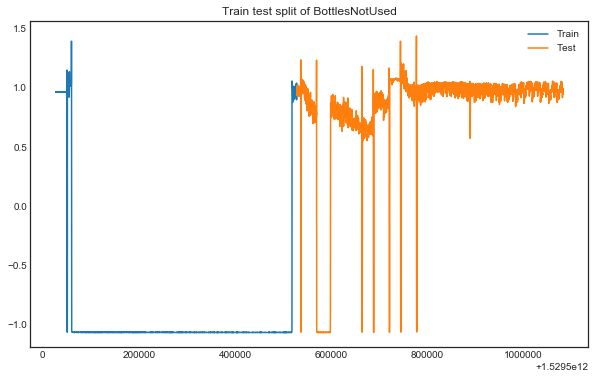

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df1.index[:x_train.shape[0]], x_train, label='Train')
ax.plot(df1.index[x_train.shape[0]:], x_test, label='Test')
ax.set(title=f'Train test split of {series}')
ax.legend()
plt.show()

In [21]:
X_train = make_windowed_dataframe(x_train, window_size) # series vector to windowed matrix
X_test = make_windowed_dataframe(x_test, window_size) # series vector to windowed matrix

print(X_train.shape, X_test.shape)

(4951, 50) (5480, 50)


In [22]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import time

es = EarlyStopping(patience=2)
mc = ModelCheckpoint(f'./models/{series}_vae_{int(time.time())}.hdf5', save_best_only=True)
hist = model.fit(X_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[es, mc])

Instructions for updating:
Use tf.cast instead.
Train on 4455 samples, validate on 496 samples
Epoch 1/50
4455/4455 [==============================] - 1s 299us/step - loss: 80.0006 - val_loss: 55.6975
Epoch 2/50
4455/4455 [==============================] - 0s 65us/step - loss: 56.7956 - val_loss: 53.7768
Epoch 3/50
4455/4455 [==============================] - 0s 66us/step - loss: 55.7442 - val_loss: 52.7686
Epoch 4/50
4455/4455 [==============================] - 0s 74us/step - loss: 54.8463 - val_loss: 52.1428
Epoch 5/50
4455/4455 [==============================] - 0s 70us/step - loss: 54.4607 - val_loss: 51.6013
Epoch 6/50
4455/4455 [==============================] - 0s 68us/step - loss: 54.2914 - val_loss: 51.5331
Epoch 7/50
4455/4455 [==============================] - 0s 69us/step - loss: 54.2025 - val_loss: 51.4190
Epoch 8/50
4455/4455 [==============================] - 0s 71us/step - loss: 54.1290 - val_loss: 51.5034
Epoch 9/50
4455/4455 [==============================] - 0s 68us/

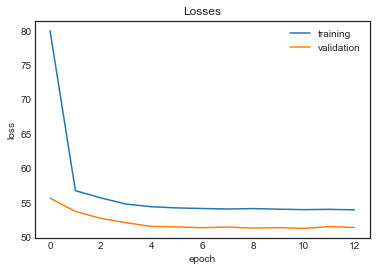

In [23]:
fig, ax = plt.subplots()
ax.plot(hist.history['loss'], label='training')
ax.plot(hist.history['val_loss'], label='validation')
ax.set(title='Losses', xlabel='epoch', ylabel='loss')
ax.legend()
plt.show()

### Anomaly Detection

To do anomaly detection, we will evaluate the model on the test data.

Since the loss returns 1 number, we should evaluate the model on sections of the test data in order to detect anomalies.

High loss should indicate higher probability of anomality (theoretically), because the reconstruction is not as well-fitted to the mean and log variance.

In [24]:
# first interval
model.evaluate(X_test[:100], verbose=0)

24.68593246459961

In [25]:
# second interval
model.evaluate(X_test[100:200], verbose=0)

8.928989486694336

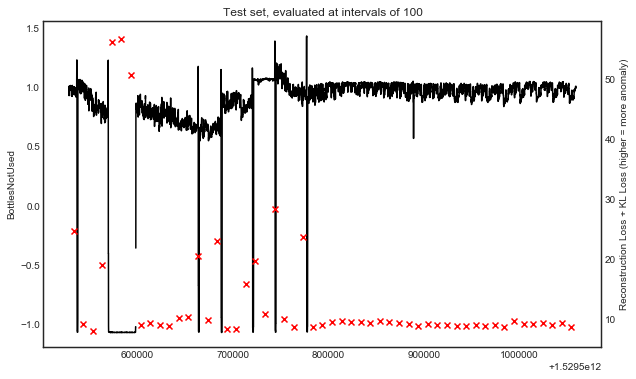

In [26]:
k = 100
n = X_test.shape[0] // k

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

for i in range(n-1):
    score = model.evaluate(X_test[i*k:(i+1)*k], verbose=0, batch_size=k)
    ax1.plot(df1.index[x_train.shape[0]:][i*k:(i+1)*k], x_test[i*k:(i+1)*k], color='black')
    ax1.set(ylabel=f'{series}')

    ax2.scatter(df1.index[x_train.shape[0]:][i*k+k//2], score, marker='x', color='red')
    ax2.set(ylabel='Reconstruction Loss + KL Loss (higher = more anomaly)')

ax1.set(title=f'Test set, evaluated at intervals of {k}')
plt.show()

# Optimization to run on Embedded Devices

After training the model, next we will see how we can optimise the model to run on a smaller device.

There are two stages:
1. [Required] Compress the model into Tensorflow Lite buffer format. This enables the model to run on embedded devices.
2. [Optional] Speed up evaluation time by replacing floating point operations with fixed point. This sacrifices model accuracy for speed.

## TensorFlow Lite Conversion

During training, the ModelCheckpoint callback already saves the best model as an HDF5 file. This file contains the model  weights only, because we used a custom loss function.

Each time you re-run training (which trains from scratch), a new HDF5 file will be created.

The filename contains a UNIX timestamp that indicates when training started.

### Supported Model Formats

Source: https://www.tensorflow.org/lite/convert#from_model_training_to_device_deployment

![image](https://www.tensorflow.org/lite/images/convert/workflow.svg)

In [27]:
# TODO: fix this path with your model file
path = f'models/{series}_vae_1558069786.hdf5'

### Loading from Keras

Since TFLiteConverter is quite new, we should confirm that we can load the model from Keras.

Since VAE uses a custom loss function, we need to define something equivalent when loading the model.

In [28]:
def reconstruction_loss(x, x_true):
    """Standalone loss function"""
    reconstruction_loss = mse(x, x_true)
    reconstruction_loss *= window_size
    #kl_loss = 1 + self.z_log_var - K.square(self.z_mean) - K.exp(self.z_log_var)
    #kl_loss = K.sum(kl_loss, axis=-1)
    #kl_loss *= -0.5
    kl_loss = 0 # workaround because we don't have access to z_mean and z_log_var
    return K.mean(reconstruction_loss + kl_loss)

In [29]:
from keras.models import load_model

vae1 = load_model(path, custom_objects={'vae_loss_func' : reconstruction_loss})
vae1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 50)                0         
_________________________________________________________________
encoder (Model)              [(None, 6), (None, 6), (N 2237      
_________________________________________________________________
decoder (Model)              (None, 50)                2125      
Total params: 4,362
Trainable params: 4,362
Non-trainable params: 0
_________________________________________________________________


In [30]:
# loss is lower (missing KL divergence) due to workaround
vae1.evaluate(X_test[:100], X_test[:100], verbose=0) 

16.127609057426454

In [31]:
vae1.evaluate(X_test[100:200], X_test[100:200], verbose=0) 

0.8229402017593384

TFLiteConverter does not accept custom loss functions for its Keras importer.

The fix is here but not yet in our version of tensorflow (even though version number tagged is lower than what we have):
https://github.com/tensorflow/tensorflow/commit/09deaeb03ca4ceb40cf600a337083e2054e65390

To address this, we change: tensorflow/lite/python/lite.py

In [32]:
import tensorflow as tf

In [33]:
# To find out where the code is located:
tf.lite.TFLiteConverter.from_keras_model_file?

# look for File: at the bottom of the output

1. Make a backup of lite.py first in case you need to revert.

2. Edit lite.py to add the change as described by the github changelist (https://github.com/tensorflow/tensorflow/commit/09deaeb03ca4ceb40cf600a337083e2054e65390#diff-51433e291e109194f883fcfc85cd2db3):

    Look for the classmethod, it should be around line 350, add a `custom_objects` parameter:
    ```
      @classmethod
      def from_keras_model_file(cls,
                                ...
                                output_arrays=None,
                                custom_objects=None):

            ...

            keras_model = _keras.models.load_model(model_file, custom_objects)
    ```

In [34]:
# force a re-import. If this doesn't work, you may need to restart the Jupyter notebook and re-run
del tf
import tensorflow as tf

In [35]:
# If using original tensorflow (v1.13), get:
#  ValueError: Unknown loss function:vae_loss_func
#
# Fix is to apply the changes to lite.py:
#  https://github.com/tensorflow/tensorflow/commit/09deaeb03ca4ceb40cf600a337083e2054e65390

converter = tf.lite.TFLiteConverter.from_keras_model_file(path,
    custom_objects={'vae_loss_func' : reconstruction_loss})

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 14 variables.
INFO:tensorflow:Converted 14 variables to const ops.
